In [218]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
from config import api_key
import requests
import json
from datetime import datetime

In [219]:
tickers = ["AAPL", "GOOG", "AMZN"]

dummy = pd.DataFrame(columns = ["ticker", "o", "c", "t"])

#create loop to run through URL & save info into lists
for name in tickers:
    base_url = f"https://api.polygon.io/v2/aggs/ticker/{name}/range/1/day/2012-01-01/2022-10-24?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    response = requests.get(base_url).json()
    datadata = pd.json_normalize(response["results"])
    datadata["ticker"] = name
    datadata = datadata[["ticker", "o", "c", "t"]]

#print(datadata)
    dummy = pd.concat([dummy,datadata])
dummy.columns=["ticker", "open", "close", "date"]

#pd.concat([dummy,datadata],axis=0)
print(dummy.head())


  ticker     open    close           date
0   AAPL  21.2457  21.2614  1351656000000
1   AAPL  21.3650  21.3050  1351742400000
2   AAPL  21.2818  20.6000  1351828800000
3   AAPL  20.8398  20.8793  1352091600000
4   AAPL  21.0796  20.8161  1352178000000


In [220]:
#Print types
#dummy.info()
#Convert unix to datetime & remove hours/miuntes
dummy['date'] = pd.to_datetime(dummy['date'],unit='ms')
dummy["date"] = pd.to_datetime(dummy["date"]).dt.date
#dummy.head()

In [221]:
#Create copy of dummy
tickers_copy = dummy.copy(deep=True)
#delete
del tickers_copy["open"]
#tickers_copy
#Create copy of dummy for %change & $change
tickers_pctchange = tickers_copy.copy(deep=True)


#Divide dataframes into new dataframes by ticker
aapl_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AAPL"]
aapl_daily2 = pd.DataFrame(aapl_daily2)
#print(aapl_daily2.head())
amzn_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AMZN"]
amzn_daily2 = pd.DataFrame(amzn_daily2)
#print(amzn_daily2.head())
goog_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "GOOG"]
goog_daily2 = pd.DataFrame(goog_daily2)
#print(goog_daily2.head())

#rename close as ticker to prepare to merge by date
aapl_daily2.rename(columns = {'close':'AAPL'}, inplace = True)
del aapl_daily2["ticker"]
amzn_daily2.rename(columns = {'close':'AMZN'}, inplace = True)
del amzn_daily2["ticker"]
goog_daily2.rename(columns = {'close':'GOOG'}, inplace = True)
del goog_daily2["ticker"]

#make copy for prices 
aapl_prices = aapl_daily2.copy(deep=True)
amzn_prices = amzn_daily2.copy(deep=True)
goog_prices = goog_daily2.copy(deep=True)
#print(aapl_prices)

#make copy for $ changes
aapl_bch = aapl_daily2.copy(deep=True)
amzn_bch = amzn_daily2.copy(deep=True)
goog_bch = goog_daily2.copy(deep=True)
#print(goog_bch)

#calculate % change
aapl_daily2["AAPL"]=aapl_daily2["AAPL"].pct_change()*100
amzn_daily2["AMZN"]=amzn_daily2["AMZN"].pct_change()*100
goog_daily2["GOOG"]=goog_daily2["GOOG"].pct_change()*100
aapl_daily2 = aapl_daily2[["date", "AAPL"]]

#calculate $ change
aapl_bch["AAPL"]=aapl_bch["AAPL"].diff()
amzn_bch["AMZN"]=amzn_bch["AMZN"].diff()
goog_bch["GOOG"]=goog_bch["GOOG"].diff()
#amzn_bch.head()
#aapl_daily2

In [222]:
#merge tables % change
merge_pctchange = aapl_daily2.merge(amzn_daily2, on='date', how='left')
merge_pctchange = merge_pctchange.merge(goog_daily2, on="date", how="left")
#merge_pctchange.head()

#merge tables prices 
merge_prices = aapl_prices.merge(amzn_prices, on='date', how='left')
merge_prices = merge_prices.merge(goog_prices, on="date", how="left")

#merge tables $change
merge_bch = aapl_bch.merge(amzn_bch, on='date', how='left')
merge_bch = merge_bch.merge(goog_bch, on="date", how="left")
merge_bch.head()

#reorder columns
merge_pctchange= merge_pctchange[['date','AAPL','GOOG', "AMZN"]]
merge_prices= merge_prices[['date','AAPL','GOOG', "AMZN"]]
merge_bch= merge_bch[['date','AAPL','GOOG', "AMZN"]]
#merge_bch
#merge_pctchange
#aapl_bch.head()

In [234]:

#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure(figsize=(100,200))
gs=plt.GridSpec(32,4, hspace=0.8, wspace = 0.3)
plt.rc('xtick', labelsize=70)
plt.rc('ytick', labelsize=70) 
#AAPL subplots
ax_aapl_bar_z=fig.add_subplot(gs[0:2, 0:3])
ax_aapl_bar_z.bar(aapl_bch["date"], aapl_bch["AAPL"], align='center')
ax_hist_aapl_y=fig.add_subplot(gs[2:4,0:3],  sharey=ax_hist_aapl_y)
ax_hist_aapl_y.hist(aapl_prices["AAPL"])
ax_scatter_aapl=fig.add_subplot(gs[4:8, 0:3])
ax_scatter_aapl.scatter(aapl_daily2["date"], aapl_daily2["AAPL"])
ax_hist_aapl_x=fig.add_subplot(gs[4:8,3])
ax_hist_aapl_x.hist(aapl_daily2["AAPL"], orientation="horizontal")
#add AMZN subplots
ax_amzn_bar=fig.add_subplot(gs[8:10, 0:3])
ax_amzn_bar.bar(amzn_bch["date"], amzn_bch["AMZN"], align='center')
ax_hist_amzn_y=fig.add_subplot(gs[10:12,0:3])
ax_hist_amzn_y.hist(amzn_prices["AMZN"])
ax_scatter_amzn=fig.add_subplot(gs[12:16, 0:3])
ax_scatter_amzn.scatter(amzn_daily2["date"], amzn_daily2["AMZN"])
ax_hist_amzn_x=fig.add_subplot(gs[12:16,3])
ax_hist_amzn_x.hist(amzn_daily2["AMZN"], orientation="horizontal")
#add GOOGL subplots
ax_goog_bar=fig.add_subplot(gs[16:20, 0:3])
ax_goog_bar.bar(goog_bch["date"], goog_bch["GOOG"], align='center')
ax_hist_goog_y=fig.add_subplot(gs[20:24,0:3])
ax_hist_goog_y.hist(goog_prices["GOOG"])
ax_scatter_goog=fig.add_subplot(gs[24:32, 0:3])
ax_scatter_goog.scatter(goog_daily2["date"], goog_daily2["GOOG"])
ax_hist_goog_x=fig.add_subplot(gs[24:32,3])
ax_hist_goog_x.hist(goog_daily2["GOOG"], 40,orientation="horizontal")
plt.show()

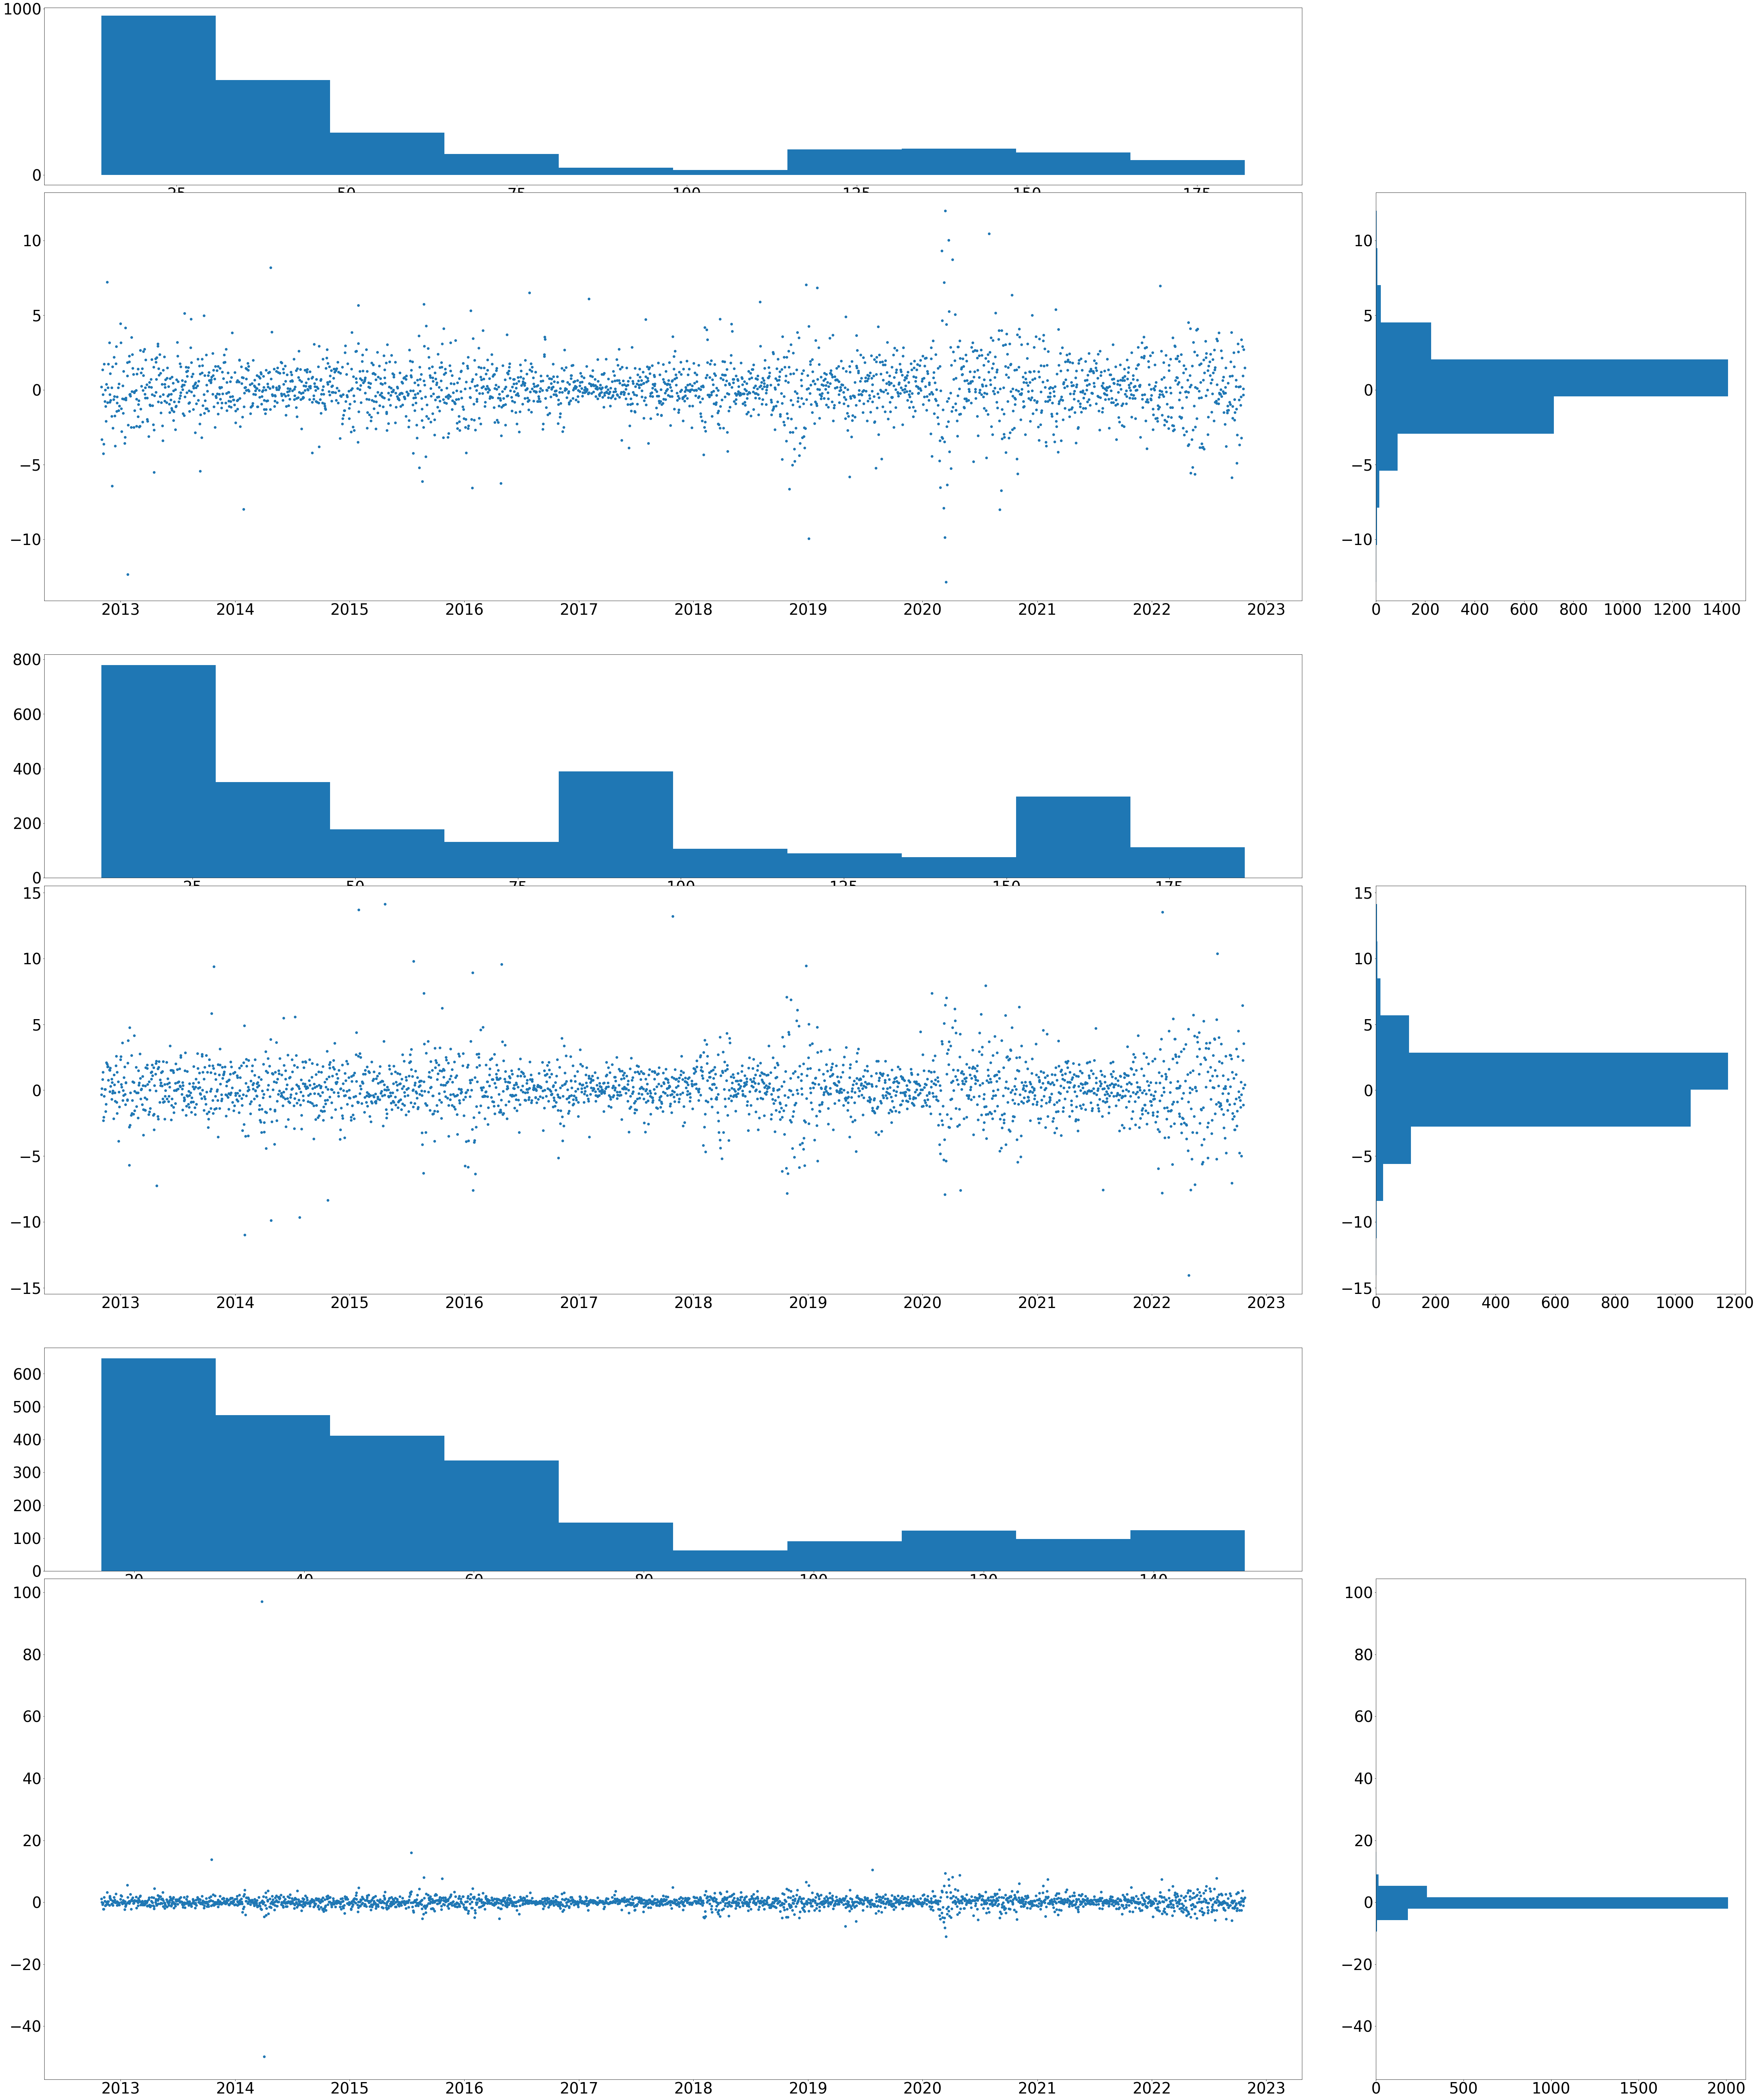

In [232]:
#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure(figsize=(80,100))
gs=plt.GridSpec(45,4,hspace=0.2, wspace=0.2)
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40) 
#AAPL subplots
ax_hist_aapl_y=fig.add_subplot(gs[0:4,0:3],  sharey=ax_hist_aapl_y)
ax_hist_aapl_y.hist(aapl_prices["AAPL"])

ax_scatter_aapl=fig.add_subplot(gs[4:13, 0:3])
ax_scatter_aapl.scatter(aapl_daily2["date"], aapl_daily2["AAPL"])
ax_hist_aapl_x=fig.add_subplot(gs[4:13,3])
ax_hist_aapl_x.hist(aapl_daily2["AAPL"], orientation="horizontal")
#add AMZN subplots
ax_hist_amzn_y=fig.add_subplot(gs[14:19,0:3])
ax_hist_amzn_y.hist(amzn_prices["AMZN"])
ax_scatter_amzn=fig.add_subplot(gs[19:28, 0:3])
ax_scatter_amzn.scatter(amzn_daily2["date"], amzn_daily2["AMZN"])
ax_hist_amzn_x=fig.add_subplot(gs[19:28,3])
ax_hist_amzn_x.hist(amzn_daily2["AMZN"], orientation="horizontal")
#add GOOGL subplots

ax_hist_goog_y=fig.add_subplot(gs[29:34,0:3])
ax_hist_goog_y.hist(goog_prices["GOOG"])
ax_scatter_goog=fig.add_subplot(gs[34:45, 0:3])
ax_scatter_goog.scatter(goog_daily2["date"], goog_daily2["GOOG"])
ax_hist_goog_x=fig.add_subplot(gs[34:45,3])
ax_hist_goog_x.hist(goog_daily2["GOOG"], 40,orientation="horizontal")
plt.show()

In [81]:
#aapl_plot, = plt.plot(merge_pctchange["date"], merge_pctchange["AAPL"], color="blue", label="AAPL" )
#amzn, = plt.plot(merge_pctchange["date"], merge_pctchange["AMZN"], color="red", label="AMZN" )
#goog, = plt.plot(merge_pctchange["date"], merge_pctchange["GOOG"], color="green", label="GOOG" )
#plt.show()

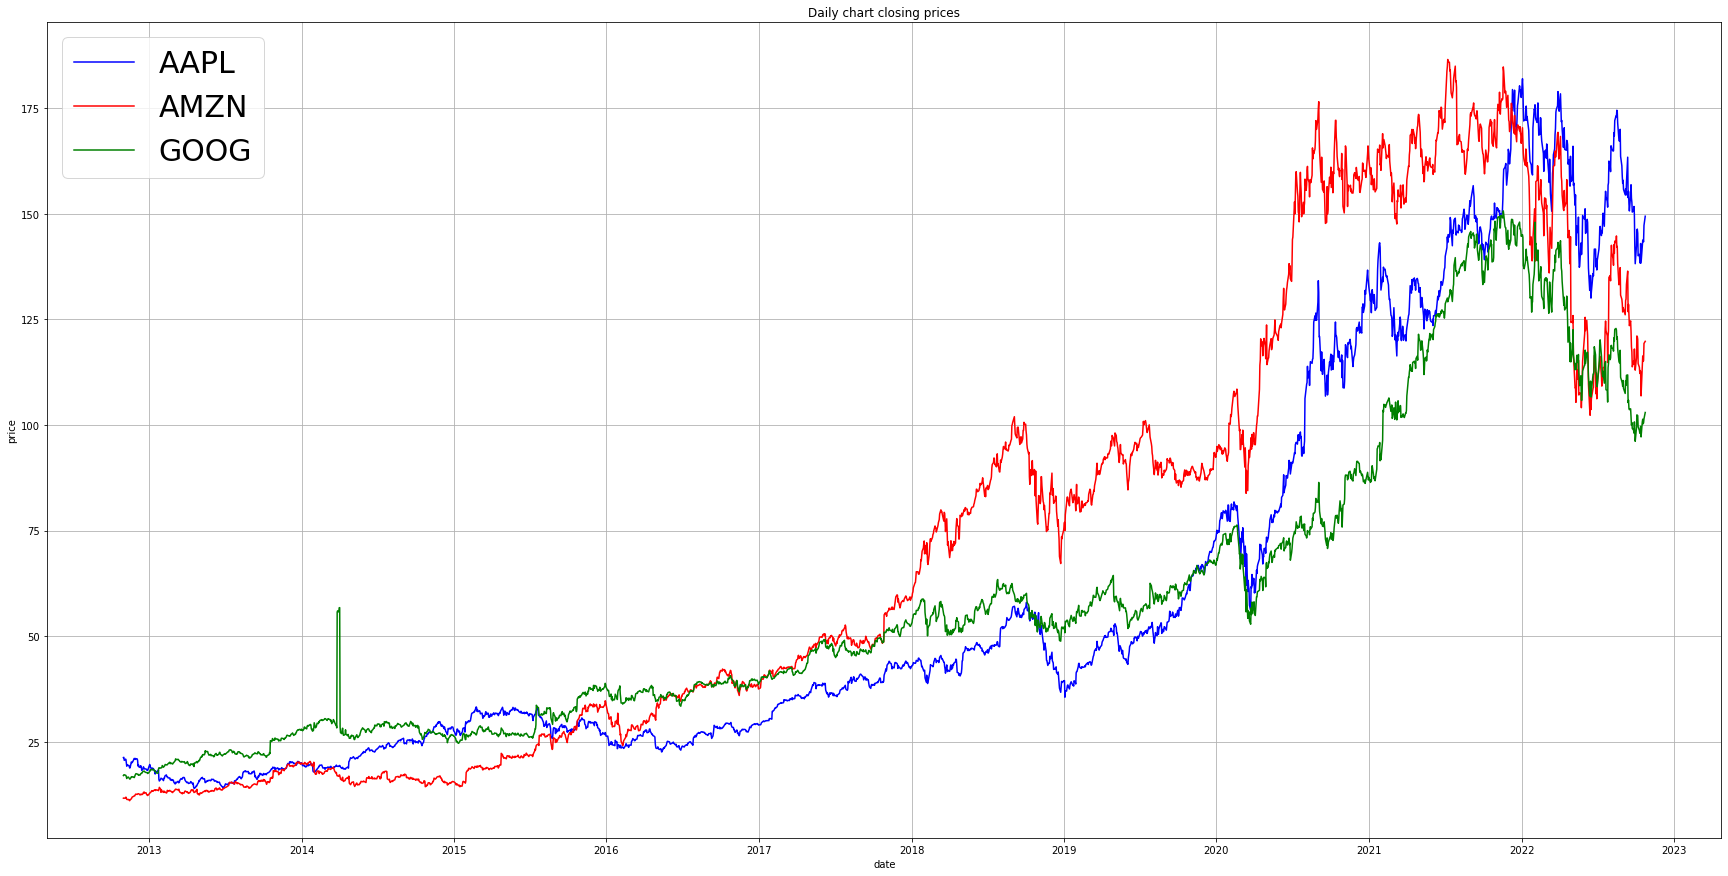

In [12]:
plt.figure(figsize=(30,15))
aapl_daily_chart, = plt.plot(merge_bch["date"], merge_bch["AAPL"], color='blue', label="AAPL")
amzn_daily_chart, = plt.plot(merge_bch["date"], merge_bch["AMZN"], color='red', label="AMZN")
goog_daily_chart, = plt.plot(merge_bch["date"], merge_bch["GOOG"], color='green', label="GOOG")
plt.grid()
plt.xlabel("date")
plt.ylabel("price")
plt.title("Daily chart closing prices")
plt.legend(fontsize = "30",loc="upper left")